# Time-of-Day and Day-of-Week Effects
Given that the crypto markets are open 24/7, it's possible that there are different patterns at different times of day or days of the week.

# Data
We use the historical price data over the last 3 years from 10 cryptocurrencies: Bitcoin (BTC), Ethereum (ETH), BinanceCoin (BNB), Cardano (ADA), XRP (XRP), Solana (SOL), Polkadot (DOT), LiteCoin (LTC), Avalanche (AVAX), Polygon (MATIC). All to in reference to Tether (USDT).

In [ ]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
from pytz import timezone

client = bnb_client(tld='US')

def get_binance_px(symbol,freq,start_ts = '2020-01-01',end_ts='2022-06-30'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']
    
    
    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    
    return data 

univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT', 'SOLUSDT', 'LTCUSDT', 'AVAXUSDT']

# Strategy
We first compute hourly returns for each cryptocurrencies over the last 3 to 1 years.

In [ ]:
#hourly returns
freqH = '1h'
pxH = {}
for x in univ:
    data = get_binance_px(x,freqH)
    pxH[x] = data.set_index('open_time')['close']

pxH = pd.DataFrame(pxH).astype(float)
pxH = pxH.reindex(pd.date_range(pxH.index[0],pxH.index[-1],freq=freqH))
retH = pxH.pct_change()

We now create a function that will take the hourly returns and a lookback window and calculate a momentum-based trading strategy for each hour, independent of the day, by computing rank-demean-normalized signal over the specified lookback window in order to identify patterns at different time-horizons.

In [ ]:
def compute_strategy_expanded(df, lookback_days):
    df['hours'] = df.index.hour

    hours = df.index.hour.unique().sort_values()

    columns = pd.MultiIndex.from_product([hours], names=['hour'])
    strats = pd.DataFrame(index=df.index, columns=columns)

    for hour in hours:
        comb = df[df['hours'] == hour].drop(columns=['hours'])
        avg_ret = comb.rolling(lookback_days, min_periods=1).mean()
        avg_ret_rank = avg_ret.rank(axis=1)
        avg_ret_rank = avg_ret_rank.subtract(avg_ret_rank.mean(axis=1), axis=0)
        avg_ret_rank = avg_ret_rank.divide(avg_ret_rank.abs().sum(axis=1), axis=0)
        strats[hour] = (avg_ret_rank.shift() * comb).sum(axis=1)

    # Sum across all the strategies (hour combinations)
    strat_total = strats.sum(axis=1)

    return strat_total

Using this function we want to investigates if the same hour has momentum, regardless of its day. 

In [ ]:
lookback_range = range(1, 31)  # This tests lookback periods from 1 to 30 days.


results = {}
strat_total_2 = {}

for lookback_days in lookback_range:
    # Compute the strategy for this lookback period.
    strat_total = compute_strategy_expanded(retH, lookback_days)
    strat_total_2[lookback_days] = strat_total 
    
    # Compute performance metrics for this strategy.
    sharpe_ratio = strat_total.mean() / strat_total.std() * np.sqrt(365*24)
    cumulative_return = strat_total.cumsum().iloc[-1]
    results[lookback_days] = {'sharpe_ratio': sharpe_ratio, 'cumulative_return': cumulative_return}

strat_total_2 = pd.DataFrame(strat_total_2)
results_df = pd.DataFrame(results).T

In [ ]:
#results_df.plot(subplots=True)
results_df.sort_values('sharpe_ratio', ascending=False)

We find very positive results indicating that a same hour shows reversal untill time-horizon of 9 days and momentum after. 

In an attempt to idenfity the most impactful times of days and days of weeks to thes result, we seperate between regular hours/ after hours and weekday/weekends

In [ ]:
strat_total_2['hours'] = strat_total_2.index.hour
strat_total_2['weekday'] = strat_total_2.index.weekday

regular_hours = ['14:00', '21:00'] #US time zone 
after_hours = ['00:00', '13:00', '22:00', '23:00'] #because between_time inclusive on both bounds and US time zone 
weekdays = [0, 1, 2, 3, 4]  
weekend = [5, 6]  

# Create separate dataframes for regular hours and after hours
reg_hours_df = strat_total_2.between_time(regular_hours[0], regular_hours[1]).copy()
after_hours_df = pd.concat([strat_total_2.between_time(after_hours[0], after_hours[1]), strat_total_2.between_time(after_hours[2], after_hours[3])]).copy()

# Create separate dataframes for weekdays and weekends
weekdays_df = strat_total_2[strat_total_2.index.weekday.isin(weekdays)].copy()
weekend_df = strat_total_2[strat_total_2.index.weekday.isin(weekend)].copy()

frames = [reg_hours_df, after_hours_df, weekdays_df, weekend_df]
sr_strats = {}
sr_strats['reg_hours'] = frames[0].mean() / frames[0].std() * np.sqrt(365*6)
sr_strats['after_hours'] = frames[1].mean() / frames[1].std() * np.sqrt(365*18)
sr_strats['weekdays'] = frames[2].mean() / frames[2].std() * np.sqrt(252*24)
sr_strats['weekend'] = frames[3].mean() / frames[3].std() * np.sqrt(113*24)
sr_strats = pd.DataFrame(sr_strats)

Although the results show potential, we try to get more precise. 

In [ ]:
#test weekdays and weekends crossed with reg and after  
after_hours_weekdays_df = after_hours_df[after_hours_df.index.weekday.isin(weekdays)].copy()
after_hours_weekend_df = after_hours_df[after_hours_df.index.weekday.isin(weekend)].copy()

reg_hours_weekdays_df = reg_hours_df[reg_hours_df.index.weekday.isin(weekdays)].copy()
reg_hours_weekend_df = reg_hours_df[reg_hours_df.index.weekday.isin(weekend)].copy()



opt_frames = [after_hours_weekdays_df, after_hours_weekend_df, reg_hours_weekdays_df, reg_hours_weekend_df]
sr_opt_strats = {}
sr_opt_strats['after_hours_weekdays'] = opt_frames[0].mean() / opt_frames[0].std() * np.sqrt(252*18)
sr_opt_strats['after_hours_weekend'] = opt_frames[1].mean() / opt_frames[1].std() * np.sqrt(113*18)
sr_opt_strats['reg_hours_weekdays'] = opt_frames[2].mean() / opt_frames[2].std() * np.sqrt(252*18)
sr_opt_strats['reg_hours_weekend'] = opt_frames[3].mean() / opt_frames[3].std() * np.sqrt(113*18)
sr_opt_strats = pd.DataFrame(sr_opt_strats)
sr_opt_strats = sr_opt_strats.drop(['hours', 'weekday'])
sr_opt_strats

# Hypothesis
- H1 : For after-hours on weekdays we find very strong reversal at time-horizon 1 to 2 days.
- H2 : For regular-hours on weekends we find very strong reversal at time-horizon 1 to 8 days.
- H3 : For regular-hours on weekdays we find very strong momentum at time-horizon 9 to 21 days.

We therefore want to trade at these hours on our signal

# Backtest
We now create signal that trades reversal at times and lookback said and same for the momentum
then backtest it against the most recent years.

In [6]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
from pytz import timezone

client = bnb_client(tld='US')

def get_binance_px_backtest(symbol,freq,start_ts = '2022-06-30',end_ts='2023-07-15'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']
    
    
    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    
    return data 

univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT', 'SOLUSDT', 'LTCUSDT', 'AVAXUSDT']

In [37]:
def compute_strategy_backtest(df, lookback_days, momentum):
    df['hours'] = df.index.hour

    hours = df.index.hour.unique().sort_values()

    columns = pd.MultiIndex.from_product([hours], names=['hour'])
    strats = pd.DataFrame(index=df.index, columns=columns)

    for hour in hours:
        comb = df[df['hours'] == hour].drop(columns=['hours'])
        avg_ret = comb.rolling(lookback_days, min_periods=1).mean()
        avg_ret_rank = avg_ret.rank(axis=1, ascending=momentum)
        avg_ret_rank = avg_ret_rank.subtract(avg_ret_rank.mean(axis=1), axis=0)
        avg_ret_rank = avg_ret_rank.divide(avg_ret_rank.abs().sum(axis=1), axis=0)
        strats[hour] = (avg_ret_rank.shift() * comb).sum(axis=1)

    # Sum across all the strategies (hour combinations)
    strat_total = strats.sum(axis=1)

    return strat_total

In [8]:
#strat prep
def stratPrep(returns, start, end,  momentum):
    lookback_range = range(start, end + 1) 


    results = {}
    strat_total_2 = {}

    for lookback_days in lookback_range:
        # Compute the strategy for this lookback period.
        strat_total = compute_strategy_backtest(returns, lookback_days, momentum)
        strat_total_2[lookback_days] = strat_total 

        # Compute performance metrics for this strategy.
        sharpe_ratio = strat_total.mean() / strat_total.std() * np.sqrt(365*24)
        cumulative_return = strat_total.cumsum().iloc[-1]
        results[lookback_days] = {'sharpe_ratio': sharpe_ratio, 'cumulative_return': cumulative_return}

    strat_total_2 = pd.DataFrame(strat_total_2)
    results_df = pd.DataFrame(results).T
    return strat_total_2, results_df

In [9]:
#hourly returns
freqH = '1h'
pxHB = {}
for x in univ:
    data = get_binance_px_backtest(x,freqH)
    pxHB[x] = data.set_index('open_time')['close']

pxHB = pd.DataFrame(pxHB).astype(float)
pxHB = pxHB.reindex(pd.date_range(pxHB.index[0],pxHB.index[-1],freq=freqH))
retHB = pxHB.pct_change()
retHB

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,SOLUSDT,LTCUSDT,AVAXUSDT
2022-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30 01:00:00,-0.000923,-0.006191,-0.005784,-0.002625,NaN,0.001445,-0.018480,-0.024007,-0.001699,-0.016166
2022-06-30 02:00:00,0.003159,0.005411,0.008803,0.006399,NaN,0.007215,0.014644,0.012058,0.005674,0.018192
2022-06-30 03:00:00,-0.000013,0.001208,-0.001555,0.000917,NaN,-0.011461,0.002062,-0.001056,-0.002445,-0.001729
2022-06-30 04:00:00,-0.001491,-0.002486,-0.000692,-0.003752,NaN,0.000000,-0.018519,-0.011043,-0.000754,-0.005774
...,...,...,...,...,...,...,...,...,...,...
2023-07-14 20:00:00,0.003809,0.002108,0.006864,0.010704,0.020836,0.008068,0.003064,0.003837,0.006538,0.011921
2023-07-14 21:00:00,0.000497,0.006399,0.007127,0.000407,0.014640,0.005770,0.014382,0.014908,0.006070,0.007623
2023-07-14 22:00:00,0.000213,-0.000135,-0.000923,0.000407,0.000416,-0.000925,0.005019,-0.006026,-0.003387,-0.004127
2023-07-14 23:00:00,0.002698,0.004030,0.010779,0.003256,-0.001525,0.007964,0.009363,0.011368,0.009877,0.011050


In [11]:
retHB['hours'] = retHB.index.hour
retHB['weekday'] = retHB.index.weekday

regular_hours = ['14:00', '21:00'] #US time zone 
after_hours = ['00:00', '13:00', '22:00', '23:00'] #because between_time inclusive on both bounds and US time zone 
weekdays = [0, 1, 2, 3, 4]  
weekend = [5, 6]  

# Create separate dataframes for regular hours and after hours
reg_hours_dfB = retHB.between_time(regular_hours[0], regular_hours[1]).copy()
after_hours_dfB = pd.concat([retHB.between_time(after_hours[0], after_hours[1]), retHB.between_time(after_hours[2], after_hours[3])]).copy()

# Create separate dataframes for weekdays and weekends
weekdays_dfB = retHB[retHB.index.weekday.isin(weekdays)].copy()
weekend_dfB = retHB[retHB.index.weekday.isin(weekend)].copy()

#test weekdays and weekends crossed with reg and after  
after_hours_weekdays_dfB = after_hours_dfB[after_hours_dfB.index.weekday.isin(weekdays)].copy()
after_hours_weekend_dfB = after_hours_dfB[after_hours_dfB.index.weekday.isin(weekend)].copy()

reg_hours_weekdays_dfB = reg_hours_dfB[reg_hours_dfB.index.weekday.isin(weekdays)].copy()
reg_hours_weekend_dfB = reg_hours_dfB[reg_hours_dfB.index.weekday.isin(weekend)].copy()

In [264]:
'''strats[2] = stratPrep(reg_hours_weekend_df, 1, 8, False)
strats[3] = stratPrep(reg_hours_weekdays_df, 9, 21, True)
strats = pd.DataFrame(strats)
strats'''

H1 = stratPrep(after_hours_weekdays_dfB.drop(columns=['hours', 'weekday']), 1, 2, False)
H2 = stratPrep(reg_hours_weekend_dfB.drop(columns=['hours', 'weekday']), 1, 8, False)
H3 = stratPrep(reg_hours_weekdays_dfB.drop(columns=['hours', 'weekday']), 9, 21, True)

# Results
H1 and H3 are verified. However H2 is incoherent and is therefore dropped from our research.

# Tcosts
We know modify the compute_strategy_function to incroporate t_costs

In [72]:
def compute_strategy_backtest_tcosts(df, lookback_days, momentum, tcost):
    df['hours'] = df.index.hour

    hours = df.index.hour.unique().sort_values()

    columns = pd.MultiIndex.from_product([hours], names=['hour'])
    strats = pd.DataFrame(index=df.index, columns=columns)

    for hour in hours:
        comb = df[df['hours'] == hour].drop(columns=['hours'])
        avg_ret = comb.rolling(lookback_days, min_periods=1).mean()
        avg_ret_rank = avg_ret.rank(axis=1, ascending=momentum)
        avg_ret_rank = avg_ret_rank.subtract(avg_ret_rank.mean(axis=1), axis=0)
        avg_ret_rank = avg_ret_rank.divide(avg_ret_rank.abs().sum(axis=1), axis=0)
        strats[hour] = (avg_ret_rank.shift() * comb).sum(axis=1) * (1 - tcost)   
        
    strat_total = strats.sum(axis=1)
    return strat_total

In [85]:
def stratPrep_tcost(returns, start, end,  momentum):
    lookback_range = range(start, end + 1) 


    results = {}
    strat_total_2 = {}

    for lookback_days in lookback_range:
        # Compute the strategy for this lookback period.
        strat_total = compute_strategy_backtest_tcosts(returns, lookback_days, momentum, 0.002)
        strat_total_2[lookback_days] = strat_total 

        # Compute performance metrics for this strategy.
        sharpe_ratio = strat_total.mean() / strat_total.std() * np.sqrt(365*24)
        cumulative_return = strat_total.cumsum().iloc[-1]
        results[lookback_days] = {'sharpe_ratio': sharpe_ratio, 'cumulative_return': cumulative_return}

    strat_total_2 = pd.DataFrame(strat_total_2)
    results_df = pd.DataFrame(results).T
    return strat_total_2, results_df



In [265]:
H1 = stratPrep_tcost(after_hours_weekdays_dfB.drop(columns = ['hours', 'weekday']), 1, 2, False)
H3 = stratPrep_tcost(reg_hours_weekdays_dfB.drop(columns = ['hours', 'weekday']), 9, 21, True)

Per project guidelines, we have incroporated the 20bps tcosts which does not make our strategy obsolete

# Weighting
We have found one reversal and one momentum strategies to trade on. We now want to define our portfolio weights for the strategies. However we need to first define weighting for each time horizons.

In [138]:
def optimal_weights(sigma,mu):
    wgt = np.linalg.inv(sigma) @ mu 
    wgt = wgt / np.abs(wgt).sum()
    return wgt

In [121]:
def sr_weights(sigma,mu):
    wgt = mu / np.diag(sigma) 
    wgt = wgt / np.abs(wgt).sum()
    return wgt

In [149]:
#S1 weighting
sigma = H1[0].cov()
mu = H1[0].mean()

S1W = pd.DataFrame(sr_weights(sigma,mu)).round(3)


#S2 weighting
sigma2 = H3[0].cov()
mu2 = H3[0].mean()

S2W = pd.DataFrame(sr_weights(sigma2,mu2)).round(3)

,0
1,0.456
2,0.544


In [159]:
#S1 returns
S1R = (H1[0] * S1W[0]).sum(1)
S1R

#S2R returns
S2R = (H3[0] * S2W[0]).sum(1)
S2R

Strat_Rets = {}
Strat_Rets[1] = S1R
Strat_Rets[2] = S2R
Strat_Rets = pd.DataFrame(Strat_Rets)
Strat_Rets

,1,2
2022-06-30 00:00:00,0.000000,NaN
2022-06-30 01:00:00,0.000000,NaN
2022-06-30 02:00:00,0.000000,NaN
2022-06-30 03:00:00,0.000000,NaN
2022-06-30 04:00:00,0.000000,NaN
...,...,...
2023-07-14 19:00:00,NaN,0.002320
2023-07-14 20:00:00,NaN,0.000301
2023-07-14 21:00:00,NaN,0.000464
2023-07-14 22:00:00,-0.001131,NaN


In [169]:
# overall weighting
sigmaOS = Strat_Rets.cov()
muOS = Strat_Rets.mean()
OSW = pd.DataFrame(sr_weights(sigmaOS,muOS)).round(3)
OSW

,0
1,0.533
2,0.467


In [167]:
FinalRets = (Strat_Rets * OSW[0]).sum(1)
FinalRets = pd.DataFrame(FinalRets)
FinalRets

,0
2022-06-30 00:00:00,0.000000
2022-06-30 01:00:00,0.000000
2022-06-30 02:00:00,0.000000
2022-06-30 03:00:00,0.000000
2022-06-30 04:00:00,0.000000
...,...
2023-07-14 19:00:00,0.001083
2023-07-14 20:00:00,0.000141
2023-07-14 21:00:00,0.000217
2023-07-14 22:00:00,-0.000603


# Performance Evaluation

In [173]:
#all anualized and since strategy trades on every hour of weekdays we do 252 * 24
stats = {}
stats['Returns'] = FinalRets.mean() * 252 * 24
stats['Volatility'] = FinalRets.std() * np.sqrt(252 * 24)
stats['Sharpe Ratio'] = FinalRets.mean() / FinalRets.std() * np.sqrt(252 * 24)
stats = pd.DataFrame(stats)
stats

,Returns,Volatility,Sharpe Ratio
0,0.166983,0.082068,2.034699


0   -8.668895
dtype: float64

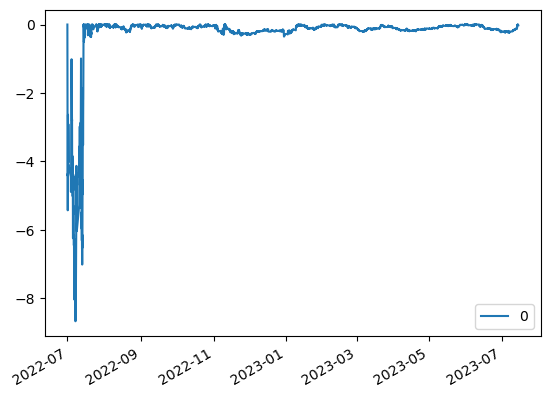

In [179]:
#drawdowns
finalCumRet = FinalRets.cumsum()

def drawdown(cumRets):
    return (cumRets / cumRets.expanding(min_periods=1).max() -1)

stratDD = drawdown(finalCumRet)
stratDD.plot()
stratDD.min() #worse point of drawdowns

0    73.416667
dtype: object

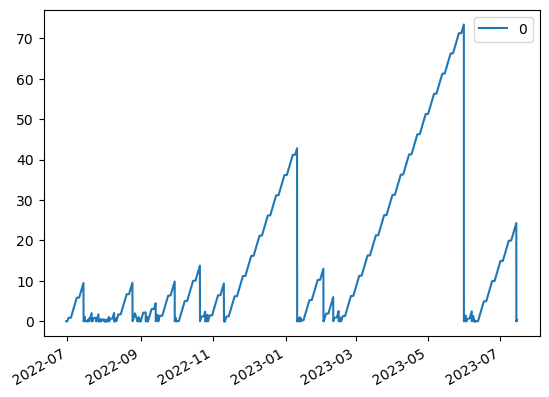

In [183]:
#drawdown duration
def duration(finalCumRet):
    
    peak = finalCumRet.expanding(min_periods=1).max()
    res = pd.DataFrame(index=finalCumRet.index,columns=finalCumRet.columns)
    
    for col in finalCumRet.columns:
        for dt in finalCumRet.index:
            
            if finalCumRet.loc[dt,col] >= peak.loc[dt,col]:
                 res.loc[dt,col] = 0
    
            else:    
                res.loc[dt,col] = res.loc[:dt,col].iloc[-2] + 1/24

    return res

stratDDD = duration(finalCumRet)
stratDDD.plot()
stratDDD.max()  #longest drawdown throughout the year

Looking at these 2 graphs seperatly could be a bit scary however as we see on the first graph we have a very low drawdown at some point which is also over a short period of time. On the other hand we see a a fex long drawdowns throughout the year but they never go very low making it not too uncomfortable.

# Regression Using StatsModels
- Run a regression to find beta and alpha of our strat to BTC
- Strat<sub>t</sub> ~ $\beta$ * BTC<sub>t</sub> + $\alpha$ + e<sub>t</sub>

In [223]:
#alpha/beta using bitcoin as benchmark
benchMark = get_binance_px_backtest('BTCUSDT','1h')
retBM = benchMark.set_index('open_time')['close']
retBM = pd.DataFrame(retBM).astype(float)
retBM = retBM.reindex(pd.date_range(retBM.index[0],retBM.index[-1],freq=freqH))
retBM = retBM.pct_change()

In [224]:
retBM['days'] = retBM.index.weekday
retBM = retBM[~retBM['days'].isin([5,6])]
rets = pd.DataFrame()
rets['strat'] = FinalRets
rets['BM'] = retBM.drop(columns='days')
rets

,strat,BM
2022-06-30 00:00:00,0.000000,NaN
2022-06-30 01:00:00,0.000000,-0.000923
2022-06-30 02:00:00,0.000000,0.003159
2022-06-30 03:00:00,0.000000,-0.000013
2022-06-30 04:00:00,0.000000,-0.001491
...,...,...
2023-07-14 19:00:00,0.001083,0.000271
2023-07-14 20:00:00,0.000141,0.003809
2023-07-14 21:00:00,0.000217,0.000497
2023-07-14 22:00:00,-0.000603,0.000213


In [246]:
import statsmodels.api as sm
X = rets[['BM']]
X = sm.add_constant(X)

Y = rets['strat']

In [245]:
X = X.drop(X.iloc[0].name)
Y = Y.drop(Y.index[0])
results = sm.OLS(Y, X).fit()

In [248]:
results.summary()
results.tvalues

const    2.053700
BM       4.937233
dtype: float64

Reconstruct our strat
- FB<sub>t</sub> ~ $\beta$ * SPY<sub>t</sub> + $\alpha$ + e<sub>t</sub>

In [250]:
strat = results.params['BM']*X['BM'] + results.params['const'] + results.resid

In [252]:
(strat-Y).abs().sum()

3.4102350476013533e-17

In [254]:
r = results.params['BM']*X['BM']
prediction = results.params['BM']*X['BM'] + results.params['const']
alpha_contr = results.params['const'] + results.resid

In [255]:
alpha_contr

2022-06-30 01:00:00    9.909775e-06
2022-06-30 02:00:00   -3.390667e-05
2022-06-30 03:00:00    1.443069e-07
2022-06-30 04:00:00    1.600760e-05
2022-06-30 05:00:00    1.995508e-05
                           ...     
2023-07-14 19:00:00    1.080328e-03
2023-07-14 20:00:00    9.985892e-05
2023-07-14 21:00:00    2.113945e-04
2023-07-14 22:00:00   -6.052181e-04
2023-07-14 23:00:00   -1.623841e-03
Length: 6527, dtype: float64

<AxesSubplot:>

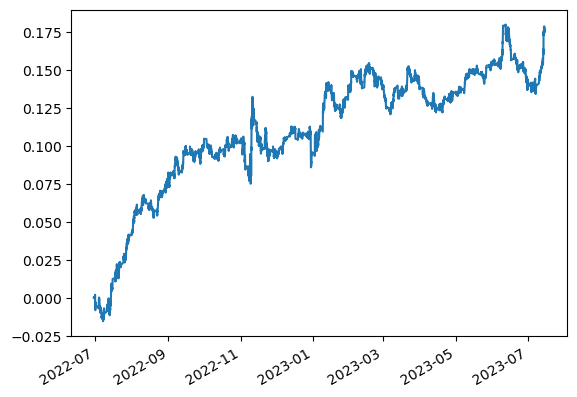

In [256]:
alpha_contr.cumsum().plot()

In [257]:
# corr is almost 0 to BM
alpha_contr.corr(X['BM'])

6.540094399242437e-17

In [258]:
#"alpha"
alpha_contr.mean()

2.678180880492585e-05

In [259]:
# information ratio
alpha_contr.mean()/alpha_contr.std()*np.sqrt(252 * 24)

1.977223289957915

In [260]:
# alpha t-stat
results.tvalues['const']

2.0537003986836893

Our regression shows that our strategy is not correlated to the 'tide' of cryptos (chose BTC as the tide) and that the information ratio was very close to the sharpe.